### Алгоритмы интеллектуальной обработки больших объемов данных

## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 28 мая 2022, 08:30  
**Штраф за опоздание:** по 1 баллу за 24 часа задержки.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


## Реализуем дерево решений (3 балла)


Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (
    KFold,
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.tree import DecisionTreeClassifier


In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(
        self,
        min_samples_split=2,
        max_depth=None,
        sufficient_share=1.0,
        criterion="gini",
        max_features=None,
    ):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == "gini":
            self.G_function = self.__gini
            self.impurity_measure = self.__gini_imp_measure
        elif criterion == "entropy":
            self.G_function = self.__entropy
            self.impurity_measure = self.__entropy_imp_measure
        elif criterion == "misclass":
            self.G_function = self.__misclass
            self.impurity_measure = self.__misclass_imp_measure
        else:
            print("invalid criterion name")
            raise

        if max_features == "sqrt":
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == "log2":
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features is None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print("invalid max_features name")
            raise

    # обозначим прирост информации IG как IG(x) = I(S) - (phi(x))
    # логично, что влиять на S на текущем шаге мы уже не можем
    # т.е. имеем const - phi(x), т.е. чтобы максимизировать прирост информации
    # нужно минимизровать phi(x). В методах ниже считается как раз phi(x)
    # (взвешенная сумма I(S_l) и I(S_r))
    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype(float)
        r_s = r_s.astype(float)
        return 1 - np.sum(
            l_c**2 / l_s.reshape(-1, 1) + r_c**2 / r_s.reshape(-1, 1), axis=1
        ) / (l_s + r_s)

    def __gini_imp_measure(self, p_c, p_s):
        p_c = p_c.astype(float)
        p_s = p_s.astype(float)
        return 1 - np.sum((p_c / p_s) ** 2)

    def __entropy(self, l_c, l_s, r_c, r_s):
        return -np.sum(
            l_c * np.log(l_c / l_s.reshape(-1, 1) + np.finfo(float).eps)
            + r_c * np.log(r_c / r_s.reshape(-1, 1) + np.finfo(float).eps),
            axis=1,
        ) / (l_s + r_s)

    def __entropy_imp_measure(self, p_c, p_s):
        p_c = p_c.astype(float)
        p_s = p_s.astype(float)
        return -np.sum((p_c / p_s) * np.log(p_c / p_s))

    def __misclass(self, l_c, l_s, r_c, r_s):
        return 1 - (np.max(l_c, axis=1) + np.max(r_c, axis=1)) / (l_s + r_s)

    def __misclass_imp_measure(self, p_c, p_s):
        p_c = p_c.astype(float)
        p_s = p_s.astype(float)
        return 1 - np.max(p_c / p_s)

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = np.asarray(range(n_feature))
        np.random.shuffle(feature_ids)
        return feature_ids[: np.sqrt(n_feature).astype(int)]

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = np.asarray(range(n_feature))
        np.random.shuffle(feature_ids)
        return feature_ids[: np.log2(n_feature).astype(int)]

    def __get_feature_ids_N(self, n_feature):
        return np.arange(n_feature)

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        # "...количественный признак сортируется по возрастанию..."
        x_sorted, y_sorted = self.__sort_samples(x, y)

        # "...проверяются только те пороги,
        # при которых целевой признак меняет значение..."
        borders = np.where(y_sorted[1:] != y_sorted[:-1])[0] + 1

        # шаблон говорит о распределении объектов классов по порогам
        # (нужен чтобы разом посчитать G_function)
        # сначала считаем количество объектов внутри бордеров
        classes_in_a_row = borders - np.append(np.array([0]), borders[:-1])

        template = np.zeros((borders.shape[0], self.num_class))

        # непосредственно указываем какому классу принадлежат объекты внутри
        template[np.arange(borders.shape[0]), y_sorted[borders - 1]] = 1

        # указываем количество объектов класса, находящихся между бордерами
        template *= classes_in_a_row.reshape(-1, 1)

        # "...для каждого порога строится дерево глубины 1..."
        l_c = np.cumsum(template, axis=0)
        r_c = np.bincount(y_sorted, minlength=self.num_class) - l_c
        l_s = np.sum(l_c, axis=1)
        r_s = y_sorted.shape[0] - l_s

        # "...считается насколько снизилась энтропия
        # (или неопределенность Джини)..."
        gs = self.G_function(l_c, l_s, r_c, r_s)

        # "...и выбираются только лучшие пороги,
        # c которыми стоит сравнивать количественный признак."
        idx = gs.argmin()
        before_border = x_sorted[int(l_s[idx]) - 1]
        after_border = x_sorted[int(l_s[idx])]
        best_threshold = np.mean([before_border, after_border])
        # © статья ODS по деревьям на хабре
        return gs[idx], best_threshold

    def __fit_node(self, x, y, node_id, depth):
        if (
            depth == self.max_depth
            or x.shape[0] <= self.min_samples_split
            or np.unique(y).shape[0] == 1
        ):
            self.tree[node_id] = (
                self.__class__.LEAF_TYPE,
                np.bincount(y).argmax(),
                np.bincount(y).astype(float) / y.shape[0],
            )
            return

        features_ids = self.get_feature_ids(x.shape[1])

        # чтобы не было проблем с шейпами и можно было
        # по argmin вытащить нужный id фичи
        feature_threshold_pairs = np.zeros((2, x.shape[1])) + np.inf

        feature_threshold_pairs[:, features_ids] = np.apply_along_axis(
            self.__find_threshold, 0, x[:, features_ids], y
        )

        # нашли как будем делить
        best_split_feature_id = np.argmin(feature_threshold_pairs[0, :])
        best_split_feature_threshold = feature_threshold_pairs[1, best_split_feature_id]
        # поделили
        x_l, x_r, y_l, y_r = self.__div_samples(
            x, y, best_split_feature_id, best_split_feature_threshold
        )

        # по пути считаем feature importances
        self.feature_importances_[best_split_feature_id] += self.impurity_measure(
            np.bincount(y), np.asarray(y.shape[0])
        ) - (
            float(y_l.shape[0])
            * self.impurity_measure(np.bincount(y_l), np.asarray(y_l.shape[0]))
            + float(y_r.shape[0])
            * self.impurity_measure(np.bincount(y_r), np.asarray(y_r.shape[0]))
        ) / float(
            y.shape[0]
        )

        # вдруг получилось так, что можно положить все в листовую ноду
        if x_l.shape[0] == 0 or x_r.shape[0] == 0:
            self.tree[node_id] = (
                self.__class__.LEAF_TYPE,
                np.bincount(y).argmax(),
                np.bincount(y).astype(float) / y.shape[0],
            )
            return

        # записали то как поделили
        self.tree[node_id] = (
            self.__class__.NON_LEAF_TYPE,
            best_split_feature_id,
            best_split_feature_threshold,
        )

        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)

        return

    def fit(self, x, y):
        self.feature_importances_ = np.zeros(x.shape[1])
        self.num_class = np.unique(y).shape[0]
        self.__fit_node(x, y, 0, 0)
        self.feature_importances_ /= y.shape[0]

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)


In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)


In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.1, stratify=wine.target
)


In [9]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)


0.8888888888888888

In [10]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
# predict сделан после исполнения ячеек ниже, ибо там обучение


0.8888888888888888

## Ускоряем дерево решений (2 балла)

Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine.
Для этого используем numpy.


In [6]:
%time clf.fit(X_train, y_train)

Wall time: 3.97 ms


DecisionTreeClassifier()

In [7]:
%time my_clf.fit(X_train, y_train)

Wall time: 28.2 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match).

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/


Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано.


In [14]:
def one_hot(data, feature):
    for code in np.sort(data[feature].unique()):
        data[feature + "=" + str(code)] = (data[feature] == code).astype(float)
    data = data.drop([feature], axis=1)


In [17]:
df = pd.read_csv("./data/Speed Dating Data.csv", encoding="latin1")
df = df.iloc[:, :97]

df = df.drop(["id"], axis=1)
df = df.drop(["idg"], axis=1)

df.drop_duplicates(subset=["iid"]).gender.value_counts()
df = df.drop(["condtn"], axis=1)

df = df.drop(["round"], axis=1)
df = df.drop(["position", "positin1"], axis=1)
df = df.drop(["order"], axis=1)
df = df.drop(["partner"], axis=1)
df = df.drop(
    [
        "age_o",
        "race_o",
        "pf_o_att",
        "pf_o_sin",
        "pf_o_int",
        "pf_o_fun",
        "pf_o_amb",
        "pf_o_sha",
        "dec_o",
        "attr_o",
        "sinc_o",
        "intel_o",
        "fun_o",
        "amb_o",
        "shar_o",
        "like_o",
        "prob_o",
        "met_o",
    ],
    axis=1,
)


df = df.dropna(subset=["age"])

df.loc[:, "field_cd"] = df.loc[:, "field_cd"].fillna(19)
df = df.drop(["field"], axis=1)

one_hot(df, "field_cd")
df = df.drop(["field_cd"], axis=1)

df = df.drop(["undergra"], axis=1)
df.loc[:, "mn_sat"] = df.loc[:, "mn_sat"].str.replace(",", "").astype(float)
df.loc[:, "mn_sat"] = df.mn_sat.fillna(-999)

df.loc[:, "tuition"] = df.loc[:, "tuition"].str.replace(",", "").astype(float)
df.loc[:, "tuition"] = df.tuition.fillna(-999)

one_hot(df, "race")

df = df.dropna(subset=["imprelig", "imprace"])
df = df.drop(["from", "zipcode"], axis=1)

df.loc[:, "income"] = df.loc[:, "income"].str.replace(",", "").astype(float)
df = df.drop(["income"], axis=1)

df = df.dropna(subset=["date"])

one_hot(df, "goal")

df.loc[:, "career_c"] = df.loc[:, "career_c"].fillna(18)
df = df.drop(["career"], axis=1)
one_hot(df, "career_c")

df = df.drop(
    [
        "sports",
        "tvsports",
        "exercise",
        "dining",
        "museums",
        "art",
        "hiking",
        "gaming",
        "clubbing",
        "reading",
        "tv",
        "theater",
        "movies",
        "concerts",
        "music",
        "shopping",
        "yoga",
    ],
    axis=1,
)

df = df.drop(["expnum"], axis=1)

feat = ["iid", "wave", "attr1_1", "sinc1_1", "intel1_1", "fun1_1", "amb1_1", "shar1_1"]
temp = df.drop_duplicates(subset=["iid", "wave"]).loc[:, feat]
temp.loc[:, "totalsum"] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[
    idx,
]
idx = (temp.wave >= 6) & (temp.wave <= 9)
temp.loc[
    idx,
]

df.loc[:, "temp_totalsum"] = df.loc[
    :, ["attr1_1", "sinc1_1", "intel1_1", "fun1_1", "amb1_1", "shar1_1"]
].sum(axis=1)

df.loc[:, ["attr1_1", "sinc1_1", "intel1_1", "fun1_1", "amb1_1", "shar1_1"]] = (
    df.loc[:, ["attr1_1", "sinc1_1", "intel1_1", "fun1_1", "amb1_1", "shar1_1"]].T
    / df.loc[:, "temp_totalsum"].T
).T * 100

feat = ["iid", "wave", "attr2_1", "sinc2_1", "intel2_1", "fun2_1", "amb2_1", "shar2_1"]
temp = df.drop_duplicates(subset=["iid", "wave"]).loc[:, feat]
temp.loc[:, "totalsum"] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)
temp.loc[idx]
idx = (temp.wave >= 6) & (temp.wave <= 9)
temp.loc[idx]
df.loc[:, "temp_totalsum"] = df.loc[
    :, ["attr2_1", "sinc2_1", "intel2_1", "fun2_1", "amb2_1", "shar2_1"]
].sum(axis=1)
df.loc[:, ["attr2_1", "sinc2_1", "intel2_1", "fun2_1", "amb2_1", "shar2_1"]] = (
    df.loc[:, ["attr2_1", "sinc2_1", "intel2_1", "fun2_1", "amb2_1", "shar2_1"]].T
    / df.loc[:, "temp_totalsum"].T
).T * 100

df = df.drop(["temp_totalsum"], axis=1)

for i in [4, 5]:
    feat = [
        "attr{}_1".format(i),
        "sinc{}_1".format(i),
        "intel{}_1".format(i),
        "fun{}_1".format(i),
        "amb{}_1".format(i),
        "shar{}_1".format(i),
    ]

    if i != 4:
        feat.remove("shar{}_1".format(i))

    df = df.drop(feat, axis=1)

df = df.drop(["wave"], axis=1)

df_male = (
    df.query("gender == 1")
    .drop_duplicates(subset=["iid", "pid"])
    .drop(["gender"], axis=1)
    .dropna()
)
df_female = (
    df.query("gender == 0")
    .drop_duplicates(subset=["iid"])
    .drop(["gender", "match", "int_corr", "samerace"], axis=1)
    .dropna()
)

df_female.columns = df_female.columns + "_f"

df_pair = df_male.join(df_female.set_index("iid_f"), on="pid", how="inner")
df_pair = df_pair.drop(["iid", "pid"], axis=1)
print("df_pair.shape =", df_pair.shape)


df_pair.shape = (3999, 156)


In [18]:
data = df_pair.iloc[:, 1:].values
target = df_pair.iloc[:, 0].values


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий информативности.
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита.
Какой максимальной точности удалось достигнуть?


In [19]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1)


In [43]:
params = {
    "max_depth": [2, 3, 4, 6, 12, 18, 24, 36, 48],
    "min_samples_split": [2, 4, 6, 8, 10, 20, 40],
}

n_splits = 3
kf = KFold(n_splits=n_splits)

res = []

for max_depth in params["max_depth"]:
    for min_samples_split in params["min_samples_split"]:
        sum_score = 0
        for train_index, val_index in kf.split(X_train):
            X, X_val = X_train[train_index], X_train[val_index]
            y, y_val = y_train[train_index], y_train[val_index]

            tree = MyDecisionTreeClassifier(
                max_depth=max_depth, min_samples_split=min_samples_split
            )
            tree.fit(X, y)

            sum_score += accuracy_score(y_pred=tree.predict(X_val), y_true=y_val)
        avg_score = sum_score / n_splits

        res.append(
            {
                "score": avg_score,
                "max_depth": max_depth,
                "min_samples_split": min_samples_split,
            }
        )


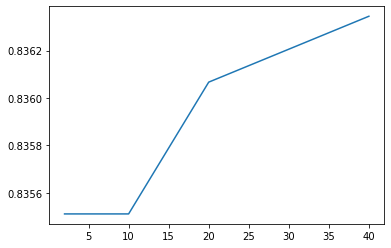

In [52]:
result = list(filter(lambda exp: exp["max_depth"] == 6, res))
# на при глубине 4 так уж вышло что прямая линия для любых min_samples_split, так хоть картинка "посложнее"

res_score = [exp["score"] for exp in result]
res_min_samples_split = [exp["min_samples_split"] for exp in result]

plt.plot(res_min_samples_split, res_score)


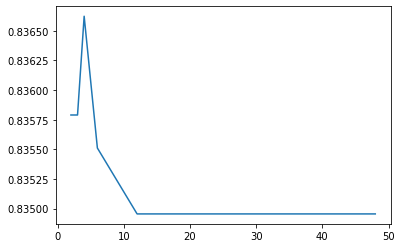

In [53]:
result = list(filter(lambda exp: exp["min_samples_split"] == 2, res))

res_score = [exp["score"] for exp in result]
res_max_depth = [exp["max_depth"] for exp in result]

plt.plot(res_max_depth, res_score)


In [54]:
best_params = res[np.argmax([exp["score"] for exp in res])]

tree = MyDecisionTreeClassifier(
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
)
tree.fit(X_train, y_train)

print(accuracy_score(y_pred=tree.predict(X_test), y_true=y_test))


0.8425


## Находим самые важные признаки (2 балла)


По построенному дереву легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно не только для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве.


Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший.
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.


Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева.


Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.


In [55]:
print(list(df_pair.columns[1:][np.flip(np.argsort(tree.feature_importances_))])[:10])


['shar2_1', 'race=4.0', 'race_f', 'attr3_1', 'go_out', 'fun1_1_f', 'date', 'race=1.0', 'goal=1.0', 'race=6.0']


## Фидбек (бесценно)


-   Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?


### Ваш ответ здесь


-   Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.


### ВАШ ОТЗЫВ ЗДЕСЬ
